In [25]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import OneHotEncoder
from skorch import NeuralNetClassifier

import sys  
sys.path.insert(0, '/root/Project-CS224N-ED-Disposition/')
from scripts import utils
import importlib
importlib.reload(utils)

index_col = 'Unnamed: 0'

In [26]:
df = pd.read_csv('/root/data/zero_shot_predictions/scores.csv').set_index(index_col)
df

,sequence,Edema,Opacities,Pericaridial effusion,Pneumonia,Pleural Effusion,Pneumothorax,Aspiration,Nephrolithiasis,Intraparenchymal hemorrhage,...,Cholecystitis,Intracranial hemorrhage,Stroke,Infection,Small bowel obstruction,Abdominal Aortic Aneurysm,Aortic dissection,Liver laceration,Colitis,Pancreatitis
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
0,1. Interval increase in perihilar opacities a...,0.929120,0.920819,0.737004,0.524612,0.185744,0.118200,0.045569,0.018194,0.014132,...,0.000431,0.000424,0.000250,0.000204,0.000184,0.000172,0.000117,0.000098,0.000074,0.000046
1,1. No acute intracranial abnormality. 2. Mil...,0.106327,0.090323,0.111382,0.000776,0.096998,0.001084,0.086613,0.028645,0.001540,...,0.018829,0.000796,0.005907,0.001479,0.000123,0.000192,0.000498,0.000157,0.011096,0.000875
2,1. Multiple loops of dilated small bowel with...,0.070339,0.741595,0.214792,0.007977,0.182043,0.072368,0.442881,0.017711,0.030738,...,0.044908,0.003074,0.008334,0.018739,0.967760,0.006287,0.003933,0.004344,0.007286,0.001242
3,1. Interval increased loculated moderate meta...,0.007522,0.441353,0.001170,0.004349,0.367867,0.008329,0.006146,0.001017,0.000746,...,0.000539,0.000267,0.000590,0.000482,0.000492,0.000297,0.000283,0.000482,0.000569,0.000209
4,1. Redemonstrated fracture of the femoral hea...,0.011500,0.378758,0.008745,0.001767,0.032812,0.004236,0.136899,0.022915,0.012002,...,0.004594,0.003910,0.008085,0.002214,0.002143,0.007413,0.001433,0.000586,0.003734,0.001374
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146144,1. Acute superior endplate compression deform...,0.412637,0.565540,0.455190,0.018393,0.451436,0.060820,0.332372,0.102796,0.499176,...,0.230802,0.094018,0.164778,0.062306,0.011410,0.113403,0.036457,0.014308,0.135798,0.009234
146145,1. Diffuse anasarca and mesenteric edema. Pat...,0.909280,0.448288,0.229874,0.259759,0.905350,0.308534,0.230740,0.140058,0.238761,...,0.055338,0.068186,0.016210,0.020335,0.006509,0.030965,0.010458,0.020484,0.012868,0.002375
146146,1. No ultrasound evidence of deep venous thro...,0.012299,0.033661,0.014146,0.005479,0.021521,0.008577,0.062111,0.035728,0.032398,...,0.017090,0.013043,0.017339,0.003024,0.000778,0.061921,0.013719,0.005801,0.001874,0.000996


In [27]:
raw_train = pd.read_csv('/root/data/ed_train.csv').set_index(index_col)
raw_val = pd.read_csv('/root/data/ed_val.csv').set_index(index_col)
raw_test = pd.read_csv('/root/data/ed_test.csv').set_index(index_col)
print(len(raw_train), len(raw_val), len(raw_test))

102304 29230 14615


In [28]:
total_rows = sum([len(raw_train), len(raw_val), len(raw_test)])
print(total_rows)
assert total_rows == len(df)

146149


In [29]:
raw_test.sort_index()[:5]

,CSN,Rads_order_ID,Study,Impression,ED_dispo
Unnamed: 0,,,,,
18,131290420384,674834819,XR CHEST 1 VIEW,No acute cardiopulmonary findings.,Discharge
23,131290420313,674835593,CT ABDOMEN PELVIS W IV CONTRAST,1. There is subtle nonspecific pericolonic/so...,Discharge
31,131290421001,674837296,CT CHEST (GATED) ABDOMEN PELVIS ANGIOGRAPHY W ...,1. Eccentric wall thickening of the descendin...,Admit to Inpatient
35,131290420892,674838159,XR CLAVICLE RIGHT,1. Normal radiographic examination of the rig...,Discharge
40,131290421720,674839438,XR CHEST 1 VIEW,No acute cardiopulmonary findings. No pneumoth...,Discharge


In [30]:
train_df = df.join(raw_train, how='right')
val_df = df.join(raw_val, how='right')
test_df = df.join(raw_test, how='right')
print(len(train_df), len(val_df), len(test_df))
assert len(train_df) == len(raw_train)
assert len(val_df) == len(raw_val)
assert len(test_df) == len(raw_test)

102304 29230 14615


In [31]:
test_df.sort_index()[:5]

,sequence,Edema,Opacities,Pericaridial effusion,Pneumonia,Pleural Effusion,Pneumothorax,Aspiration,Nephrolithiasis,Intraparenchymal hemorrhage,...,Abdominal Aortic Aneurysm,Aortic dissection,Liver laceration,Colitis,Pancreatitis,CSN,Rads_order_ID,Study,Impression,ED_dispo
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
18,No acute cardiopulmonary findings.,0.032135,0.021683,0.010302,0.000446,0.035475,0.001326,0.066773,0.033053,0.004757,...,0.003842,0.000187,0.001635,0.003037,0.000769,131290420384,674834819,XR CHEST 1 VIEW,No acute cardiopulmonary findings.,Discharge
23,1. There is subtle nonspecific pericolonic/so...,0.101627,0.426030,0.176138,0.002988,0.107366,0.034988,0.355054,0.023736,0.025704,...,0.028501,0.013193,0.004710,0.036816,0.001613,131290420313,674835593,CT ABDOMEN PELVIS W IV CONTRAST,1. There is subtle nonspecific pericolonic/so...,Discharge
31,1. Eccentric wall thickening of the descendin...,0.047456,0.273750,0.028355,0.005455,0.042542,0.028404,0.257110,0.016776,0.584988,...,0.079212,0.626246,0.000874,0.003681,0.001050,131290421001,674837296,CT CHEST (GATED) ABDOMEN PELVIS ANGIOGRAPHY W ...,1. Eccentric wall thickening of the descendin...,Admit to Inpatient
35,1. Normal radiographic examination of the rig...,0.024170,0.208880,0.120606,0.016977,0.109822,0.100500,0.018331,0.123843,0.053044,...,0.006235,0.000190,0.000948,0.042491,0.002773,131290420892,674838159,XR CLAVICLE RIGHT,1. Normal radiographic examination of the rig...,Discharge
40,No acute cardiopulmonary findings. No pneumoth...,0.111806,0.397877,0.085052,0.028231,0.185629,0.090437,0.404633,0.184121,0.017761,...,0.149854,0.027792,0.018517,0.057314,0.018991,131290421720,674839438,XR CHEST 1 VIEW,No acute cardiopulmonary findings. No pneumoth...,Discharge


In [32]:
X_train = train_df[utils.labels]
X_val = val_df[utils.labels]
X_test = test_df[utils.labels]

y_col = "ED_dispo"
y_train = train_df[[y_col]]
y_val = val_df[[y_col]]
y_test = test_df[[y_col]]

input_dim = len(X_train.columns)
output_dim = len(y_train[y_col].unique())
print(input_dim, output_dim)

31 4


In [33]:
label_enc = OneHotEncoder(handle_unknown='ignore')
label_enc.fit(y_train)
print(y_train[y_col].unique())
print(label_enc.categories_)
print(label_enc.transform(y_train).toarray())

['Admit to Inpatient' 'Discharge' 'Place in Observation-CDU'
 'Place in Observation']
[array(['Admit to Inpatient', 'Discharge', 'Place in Observation',
       'Place in Observation-CDU'], dtype=object)]
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 ...
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]]


In [34]:
class Data(Dataset):
  def __init__(self, X_train, y_train):
    # need to convert float64 to float32 else 
    # will get the following error
    # RuntimeError: expected scalar type Double but found Float
    self.X = torch.from_numpy(X_train.astype(np.float32).values)
    self.y = torch.from_numpy(label_enc.transform(y_train).toarray())
    self.len = self.X.shape[0]
  
  def __getitem__(self, index):
    return self.X[index], self.y[index]

  def __len__(self):
    return self.len

train_data = Data(X_train, y_train)
val_data = Data(X_val, y_val)
test_data = Data(X_test, y_test)
print(train_data[0])

(tensor([2.2861e-01, 1.7704e-01, 9.8265e-01, 1.3679e-01, 1.1886e-02, 1.0064e-02,
        2.8919e-01, 5.4202e-02, 5.6665e-01, 1.6432e-01, 2.1832e-03, 6.6484e-03,
        7.1663e-03, 3.9533e-03, 2.6506e-02, 2.3122e-03, 2.7663e-03, 3.0448e-02,
        6.6401e-02, 9.0901e-03, 3.4748e-03, 2.0602e-03, 1.0667e-03, 3.9875e-03,
        4.4652e-04, 2.7340e-03, 3.7073e-02, 7.0074e-02, 5.1176e-01, 2.2719e-02,
        1.4835e-03]), tensor([1., 0., 0., 0.], dtype=torch.float64))


In [35]:
batch_size = 128
num_workers = 2
train_loader = DataLoader(
    train_data,
    batch_size=batch_size, 
    shuffle=True,
#     num_workers=num_workers,
)

In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Network(nn.Module):
  def __init__(self, input_dim, output_dim, hidden_dim=64, dropout_prob=0.2, hidden_layers=1):
    super(Network, self).__init__()
    self.hidden_layers = hidden_layers
    self.dropout_in = nn.Dropout(dropout_prob)
    self.fc_in = nn.Linear(input_dim, hidden_dim)
    self.fc_out = nn.Linear(hidden_dim, output_dim)
    if hidden_layers > 1:
        self.dropout_mid = nn.Dropout(dropout_prob)
        self.fc_mid = nn.Linear(hidden_dim, hidden_dim)

  def forward(self, x):
    x = self.dropout_in(x)
    x = self.fc_in(x)
    x = F.gelu(x)
    
    if self.hidden_layers > 1:
        x = self.dropout_mid(x)
        x = self.fc_mid(x)
        x = F.gelu(x)

    x = self.fc_out(x)
    return x

Network(input_dim=5, output_dim=3, hidden_dim=32, dropout_prob=0.5, hidden_layers=2)

Network(
  (dropout_in): Dropout(p=0.5, inplace=False)
  (fc_in): Linear(in_features=5, out_features=32, bias=True)
  (fc_out): Linear(in_features=32, out_features=3, bias=True)
  (dropout_mid): Dropout(p=0.5, inplace=False)
  (fc_mid): Linear(in_features=32, out_features=32, bias=True)
)

In [37]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
classifier = Network(input_dim, output_dim, hidden_dim=32, dropout_prob=0.5, hidden_layers=2).to(device)
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-5)

epochs = 100
for epoch in range(epochs):
#     print("start epoch", epoch)
    classifier.train() # training mode, to apply dropout
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad() # set optimizer to zero grad to remove previous epoch gradients
        outputs = classifier(inputs) # forward propagation
        loss = loss_func(outputs, labels)
        loss.backward() # backward propagation
        optimizer.step()
    
    classifier.eval()
    outputs = classifier(val_data.X.to(device))
    val_data_y = val_data.y.to(device)
    loss = loss_func(outputs, val_data_y)
    
    accuracy = sum(torch.argmax(outputs, dim=1) == torch.argmax(val_data_y, dim=1)) / len(val_data_y)
    print(f'epoch {epoch}. validation loss: {loss.item()}, val acc {accuracy}')

cuda:0
epoch 0. validation loss: 1.2912895696154205, val acc 0.48905232548713684
epoch 1. validation loss: 1.2573021234203354, val acc 0.48905232548713684
epoch 2. validation loss: 1.2181590961341453, val acc 0.48905232548713684
epoch 3. validation loss: 1.1738574491597755, val acc 0.48905232548713684
epoch 4. validation loss: 1.1258436029572376, val acc 0.48905232548713684
epoch 5. validation loss: 1.077542572483558, val acc 0.48905232548713684
epoch 6. validation loss: 1.0334307481216478, val acc 0.48905232548713684
epoch 7. validation loss: 0.9966845258086501, val acc 0.48905232548713684
epoch 8. validation loss: 0.9680585532044857, val acc 0.48905232548713684
epoch 9. validation loss: 0.9473995758253052, val acc 0.5012316107749939
epoch 10. validation loss: 0.9331325039282833, val acc 0.5463564395904541
epoch 11. validation loss: 0.9232457116149363, val acc 0.5613410472869873
epoch 12. validation loss: 0.9163095930352261, val acc 0.5588436126708984
epoch 13. validation loss: 0.9110

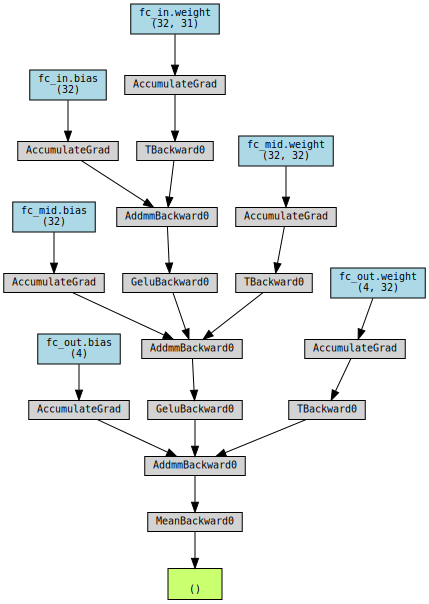

In [38]:
from torchviz import make_dot

y = classifier(val_data.X.to(device))
make_dot(y.mean(), params=dict(classifier.named_parameters()))

In [39]:
# class AverageMeter(object):
#     """Computes and stores the average and current value"""
#     def __init__(self):
#         self.reset()

#     def reset(self):
#         self.val = 0
#         self.avg = 0
#         self.sum = 0
#         self.count = 0

#     def update(self, val, n=1):
#         self.val = val
#         self.sum += val * n
#         self.count += n
#         self.avg = self.sum / self.count

# def accuracy(out, labels):
#     _,pred = torch.max(out, dim=1)
#     return torch.sum(pred==labels).item()

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(device)
# classifier = Network(input_dim, output_dim).to(device)
# loss_func = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-3, weight_decay=1e-5)

# epochs = 100
# for epoch in range(epochs):
# #     print("start epoch", epoch)
#     classifier.train() # training mode, to apply dropout
#     loss_meter = AverageMeter()
#     for i, data in enumerate(train_loader, 0):
#         inputs, labels = data
#         inputs = inputs.to(device)
#         labels = labels.to(device)
        
#         optimizer.zero_grad() # set optimizer to zero grad to remove previous epoch gradients
#         outputs = classifier(inputs) # forward propagation
#         loss = loss_func(outputs, labels)
#         loss.backward() # backward propagation
#         optimizer.step()
#         loss_meter.update(loss.item())
    
#     classifier.eval()
#     outputs = classifier(val_data.X.to(device))
#     val_data_y = val_data.y.to(device)
#     loss = loss_func(outputs, val_data_y)
    
#     accuracy = sum(torch.argmax(outputs, dim=1) == torch.argmax(val_data_y, dim=1)) / len(val_data_y)
#     print(f'epoch {epoch}. training loss: {loss_meter.avg}, validation loss: {loss.item()}, val acc {accuracy}')